## Loading Libraries

In [19]:
import pandas as pd
import numpy as np
import string
import warnings
import math
import nltk
import json
from langdetect import detect
from libsvm import *
from nltk.stem import PorterStemmer
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display

from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
import dask.dataframe as dd
import multiprocessing
import swifter
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('words')
# pd.set_option('display.max_colwidth', None)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anishajauhari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/anishajauhari/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
# pip install pyspellchecker

In [5]:
## Dataset Purification

In [6]:
# dataset = pd.read_csv("Project Dataset/dataset_2.csv")
# drop_index = []
# for index, row in dataset.iterrows():
#     try:
#         if detect(row["lyrics"]) == "en":
#             continue
#         else:
#             drop_index.append(index)
#     except Exception as e:
#         pass
# dataset = dataset.drop(drop_index)
# dataset = dataset.loc[dataset["genre"]!="Not Available"]
# dataset["genre"].value_counts()

In [7]:
dataset = pd.read_csv("filtered_dataset.csv")

In [9]:
dataset["song"] = dataset["song"].apply(lambda x : str(x).replace("-"," "))
dataset["artist"] = dataset["artist"].apply(lambda x : str(x).replace("-"," "))

In [10]:
rock_pop_dataset = dataset.loc[(dataset["genre"] == "Pop") | (dataset["genre"] == "Rock")]
rock_pop_dataset["genre"].value_counts()
# rock_pop_dataset.to_csv("rockpopdataset.csv")

Rock    94386
Pop     31157
Name: genre, dtype: int64

## Exploratory Data Analysis

<AxesSubplot:xlabel='Genre', ylabel='No of songs'>

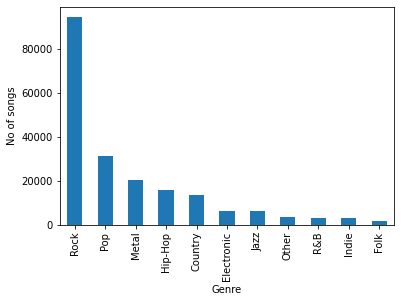

In [11]:
dataset["genre"].value_counts()
dataset["genre"].value_counts().plot(kind="bar", xlabel="Genre", ylabel="No of songs")

<AxesSubplot:xlabel='Genre', ylabel='No of songs'>

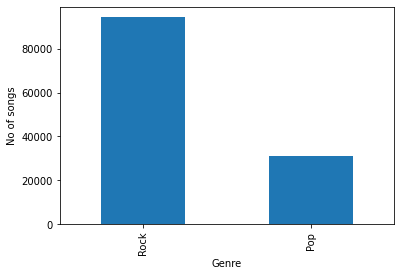

In [12]:
rock_pop_dataset['genre'].value_counts().plot(kind="bar", xlabel="Genre", ylabel="No of songs")

## Preprocessing

In [13]:
# rock_pop_dataset["genre"].value_counts()

In [14]:
ps = PorterStemmer()
stopwords = stopwords.words('english')
exclist = string.punctuation + string.digits
# remove punctuations and digits from lyrics
table_ = str.maketrans('', '', exclist)
rock_pop_dataset["filtered_lyrics"] = rock_pop_dataset["lyrics"].apply(lambda x : x.lower().translate(table_))
# stemming the lyrics
# rock_pop_dataset["filtered_lyrics"] = rock_pop_dataset["filtered_lyrics"].apply(lambda x: [ps.stem(y.lower()) for y in x.split(" ")])
# stopword removal 
rock_pop_dataset["filtered_lyrics"] = rock_pop_dataset["filtered_lyrics"].apply(lambda x : ' '.join( y for y in x.split(" ") if y not in stopwords))

In [15]:
# rock_pop_dataset.drop(columns = ["Unnamed: 0"])
target = rock_pop_dataset["genre"].astype('category').cat.codes

In [16]:
rock_pop_dataset["misspelled_words"] = rock_pop_dataset["filtered_lyrics"].apply(lambda x : len(spell.unknown(x.split())))

In [17]:
rock_pop_dataset["unique_words"] = rock_pop_dataset["filtered_lyrics"].apply(lambda x : len(set(x.split())))

In [31]:
### Replacing slang 
SMS_SLANGS = {"ain't":"is not","aren't":"are not","can't":"cannot","can't've":"cannot have",
          "'cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have",
          "didn't":"did not","doesn't":"does not","don't":"do not","hadn't":"had not","hadn't've":"had not have",
          "hasn't":"has not","haven't":"have not","he'd":"he would","he'd've":"he would have","he'll":"he will",
          "he'll've":"he he will have","he's":"he is","how'd":"how did","how'd'y":"how do you","how'll":"how will",
          "how's":"how is","I'd":"I would","I'd've":"I would have","I'll":"I will","I'll've":"I will have","I'm":"I am",
          "I've":"I have","i'd":"i would","i'd've":"i would have","i'll":"i will","i'll've":"i will have","i'm":"i am",
          "i've":"i have","isn't":"is not","it'd":"it would","it'd've":"it would have","it'll":"it will","it'll've":"it will have",
          "it's":"it is","let's":"let us","ma'am":"madam","mayn't":"may not","might've":"might have",
          "mightn't":"might not","mightn't've":"might not have","must've":"must have","mustn't":"must not","mustn't've":"must not have",
          "needn't":"need not","needn't've":"need not have","o'clock":"of the clock","oughtn't":"ought not","oughtn't've":"ought not have",
          "shan't":"shall not","sha'n't":"shall not","shan't've":"shall not have","she'd":"she would","she'd've":"she would have",
          "she'll":"she will","she'll've":"she will have","she's":"she is","should've":"should have","shouldn't":"should not",
          "shouldn't've":"should not have","so've":"so have","so's":"so as","that'd":"that would","that'd've":"that would have",
          "that's":"that is","there'd":"there would","there'd've":"there would have","there's":"there is","they'd":"they would",
          "they'd've":"they would have","they'll":"they will","they'll've":"they will have","they're":"they are","they've":"they have",
          "to've":"to have","wasn't":"was not","we'd":"we would","we'd've":"we would have","we'll":"we will","we'll've":"we will have",
          "we're":"we are","we've":"we have","weren't":"were not","what'll":"what will","what'll've":"what will have",
          "what're":"what are","what's":"what is","what've":"what have","when's":"when is","when've":"when have",
          "where'd":"where did","where's":"where is","where've":"where have","who'll":"who will","who'll've":"who will have",
          "who's":"who is","who've":"who have","why's":"why is","why've":"why have","will've":"will have","won't":"will not",
          "won't've":"will not have","would've":"would have","wouldn't":"would not","wouldn't've":"would not have","y'all":"you all",
          "y'all'd":"you all would","y'all'd've":"you all would have","y'all're":"you all are","y'all've":"you all have",
          "you'd":"you would","you'd've":"you would have","you'll":"you will","you'll've":"you will have",
          "you're":"you are","you've":"you have"}

with open('ShortendText.json','r') as file:
    abbr_dict=json.loads(file.read())
abbr_dict.update(SMS_SLANGS)
list_of_terms = abbr_dict.keys()

rock_pop_dataset["slang_words"] = rock_pop_dataset["filtered_lyrics"].apply(lambda x : len(set(list_of_terms)&set(x.split())))


In [32]:
rock_pop_dataset.sample(10)

,song,year,artist,genre,lyrics,filtered_lyrics,misspelled_words,unique_words,slang_words
37613,been there all the time,2007-01-01,dinosaur jr,Rock,Can I fix it and still care? Can I run and you...,fix still care run youll wish could run hide j...,0,37,3
173557,i am the amazon,2006-01-01,army of lovers,Pop,I am the amazon I am the amazon I am the amazo...,amazon amazon amazon amazon amazon amazon amaz...,22,40,3
12877,do you hear me anymore,2006-01-01,anything box,Pop,(claude s.) Do you hear me anymore? Do you hea...,claude hear anymore hear anymore staring sea t...,1,33,0
10745,gotta have love,2012-01-01,capital lights,Rock,"In this world, it's all about who you know And...",world know know someone thats world doubts wor...,0,69,1
32574,jack kerouac,2010-01-01,brooke fraser,Pop,He got the droop of a fatherless child Almost ...,got droop fatherless child almost imperceptibl...,4,61,2
142075,old old song,2006-01-01,ani difranco,Rock,i'll sing you a song that starts out descripti...,ill sing song starts descriptive locates time ...,0,105,2
6326,get down,2007-01-01,all 4 one,Pop,Just got done workin' On my way home and sitti...,got done workin way home sittin friday night ...,4,100,7
112610,i m still waiting,2013-01-01,five star,Pop,Cheeky little boy woth a pretty face Lost all ...,cheeky little boy woth pretty face lost abilit...,5,105,9
37709,gettin rough,1997-01-01,dinosaur jr,Rock,I know you're waiting I'm through relating I'v...,know youre waiting im relating ive enough im s...,0,46,4
115797,mountains to move,2009-01-01,gavin degraw,Rock,"Sunlight goes down, as you pack up your things...",sunlight goes pack things feelings amount work...,0,77,4


In [35]:
##### Adding Audio Features #########

song                                               welcome to jamrock
year                                                       2007-01-01
artist                                                    alicia keys
genre                                                             Pop
lyrics              Love it or leave it alone Alicia keys ft commo...
filtered_lyrics     love leave alone alicia keys ft common mos def...
misspelled_words                                                   12
unique_words                                                      214
slang_words                                                        14
Name: 173047, dtype: object

In [36]:
rock_pop_dataset.to_csv("rockpopdataset.csv")

## Feature Selection 

In [44]:
rock_pop_dataset = pd.read_csv("rockpopdataset.csv")

### Term Frequency Inverse Document Frequency - TFIDF 

In [16]:
tf_vec = TfidfVectorizer(analyzer = 'word', min_df = 5, max_df = 0.95)
X = tf_vec.fit_transform(rock_pop_dataset["filtered_lyrics"]).toarray()

In [17]:
tfidf_df = pd.DataFrame(X, columns = tf_vec.get_feature_names())

In [18]:
importance = np.argsort(np.asarray(X.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tf_vec.get_feature_names())
tf_idf_100 = tfidf_feature_names[importance[:100]]
tf_idf_200 = tfidf_feature_names[importance[:200]]
tf_idf_500 = tfidf_feature_names[importance[:500]]

In [21]:
tfidf_df_100 = tfidf_df.loc[:, tfidf_df.columns.isin(tf_idf_100)]
tfidf_df_200 = tfidf_df.loc[:, tfidf_df.columns.isin(tf_idf_200)]
tfidf_df_500 = tfidf_df.loc[:, tfidf_df.columns.isin(tf_idf_500)]

tfidf_df_100["index"] = rock_pop_dataset.index
tfidf_df_200["index"] = rock_pop_dataset.index
tfidf_df_500["index"] = rock_pop_dataset.index

tfidf_df_100["misspelled_words"] = rock_pop_dataset["misspelled_words"]
tfidf_df_200["misspelled_words"] = rock_pop_dataset["misspelled_words"]
tfidf_df_500["misspelled_words"] = rock_pop_dataset["misspelled_words"]

tfidf_df_100["unique_words"] = rock_pop_dataset["unique_words"]
tfidf_df_200["unique_words"] = rock_pop_dataset["unique_words"]
tfidf_df_500["unique_words"] = rock_pop_dataset["unique_words"]

tfidf_df_100["slang_words"] = rock_pop_dataset["slang_words"]
tfidf_df_200["slang_words"] = rock_pop_dataset["slang_words"]
tfidf_df_500["slang_words"] = rock_pop_dataset["slang_words"]

### Information Gain 

In [10]:
vectorizer = CountVectorizer(analyzer='word', min_df = 5, max_df = 0.95)
X = vectorizer.fit_transform(rock_pop_dataset["filtered_lyrics"]).toarray()

In [11]:
feature_terms = pd.DataFrame(vectorizer.get_feature_names(), columns=["Term"])
X = pd.DataFrame(X, columns = vectorizer.get_feature_names())
# X

In [12]:
rock = rock_pop_dataset.loc[rock_pop_dataset["genre"] == "Rock"]["filtered_lyrics"]
pop = rock_pop_dataset.loc[rock_pop_dataset["genre"] == "Pop"]["filtered_lyrics"]


In [13]:
# feature_terms["rock"] = feature_terms["Term"].swifter.apply(lambda a : sum(rock.str.contains(a)))
# feature_terms["pop"] = feature_terms["Term"].swifter.apply(lambda a : sum(pop.str.contains(a)))

In [14]:
feature_terms["rock"] = dd.from_pandas(feature_terms["Term"], npartitions=4*multiprocessing.cpu_count()).map_partitions(lambda dframe: dframe.apply(lambda a: sum(rock.str.contains(a)))).compute(scheduler='processes')
feature_terms["pop"] = dd.from_pandas(feature_terms["Term"], npartitions=4*multiprocessing.cpu_count()).map_partitions(lambda dframe: dframe.apply(lambda a: sum(pop.str.contains(a)))).compute(scheduler='processes')


In [15]:
# feature_terms["rock"] = feature_terms["Term"].apply(lambda a : sum(rock.str.contains(a)))

In [16]:
# feature_terms["pop"] = feature_terms["Term"].apply(lambda a : sum(pop.str.contains(a)))

In [17]:
# feature_terms

In [18]:
feature_terms["not_rock"] = 94386 - feature_terms["rock"]

In [19]:
feature_terms["not_pop"] = 31157 - feature_terms["pop"]

In [20]:
def informationGain(term, entropy):
    prob_rock = term["rock"]/(term["rock"] + term["pop"])
    prob_pop = term["pop"]/(term["rock"] + term["pop"])
    prob_not_rock = term["not_rock"]/(term["not_rock"] + term["not_pop"])
    prob_not_pop = term["not_pop"]/(term["not_rock"] + term["not_pop"])
    total_prob = (term["rock"] + term["pop"])/125543
    not_total_prob = (term["not_rock"] + term["not_pop"])/125543
    
    final_entropy = (total_prob*(-1*((prob_rock*math.log2(prob_rock) if prob_rock!=0 else 0) + (prob_pop*math.log2(prob_pop)if prob_pop!=0 else 0)))) + (not_total_prob*(-1*((prob_not_rock*math.log2(prob_not_rock) if prob_not_rock!=0 else 0) + (prob_not_pop*math.log2(prob_not_pop)if prob_not_pop!=0 else 0))))
        
    return entropy - final_entropy

In [21]:
entropy= -1 * (94386/125543) * math.log2(94386/125543) - (31157/125543) * math.log2(31157/125543)
feature_terms["info_gain"] = feature_terms.apply(lambda x : informationGain(x, entropy), axis = 1)

In [22]:
feature_terms = feature_terms.sort_values(by=["info_gain"], ascending=False)
# feature_terms

In [23]:
# feature_terms[:100]["Term"]

In [24]:
ig_terms_100 = feature_terms[:100]["Term"]
ig_terms_200 = feature_terms[:200]["Term"]
ig_terms_500 = feature_terms[:500]["Term"]

ig_100 = X.loc[:, X.columns.isin(ig_terms_100)]
ig_200 = X.loc[:, X.columns.isin(ig_terms_200)]
ig_500 = X.loc[:, X.columns.isin(ig_terms_500)]

In [25]:
# ig_500

In [26]:
ig_100["index"] = rock_pop_dataset.index
ig_200["index"] = rock_pop_dataset.index
ig_500["index"] = rock_pop_dataset.index


## Classification 

In [28]:
def convertToSparse(df):
    df_sparse = csr_matrix(df.iloc[:, :], dtype=np.int8).toarray()
    return pd.DataFrame(df_sparse, index = df.index, columns = df.columns[:])

In [29]:
def trainTestSplit(df, y):
    return train_test_split(df, y, test_size=0.20, random_state=42)

In [30]:
def model_fit(X_train, y_train, model = "NB"):
    if model == "NB":
        NB_Classifier = MultinomialNB()
        model = NB_Classifier.fit(X_train, y_train)
    elif model == "SVM":
        model = OneVsRestClassifier(BaggingClassifier(
            SVC(kernel='rbf', probability=True, class_weight='balanced'), 
                max_samples=1.0 / 10, 
                n_estimators=10))
        model.fit(X_train, y_train)
    else:
        rf = RandomForestClassifier(max_depth = 2, random_state = 0)
        model = rf.fit(X_train, y_train)
    return model

In [31]:
def evaluate_model(y_test, y_pred, model_name):
    print("\nConfusion Matrix : "+model_name)
    print(confusion_matrix(y_test, y_pred))
    print("\n*******************************")
    print("\nClassification Report : "+model_name)
    print(classification_report(y_test, y_pred))

In [32]:
def run_model(df):
    convertToSparse(df)
    X_train, X_test, y_train, y_test = trainTestSplit(df, target)
    model = model_fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_changed = pd.Series(y_pred, index = y_test.index)
#     evaluate_model(y_test, y_pred, "NB")
    print("--- Naive Bayes Misclassification ---")
    false_neg = X_test[list((y_test == 1) & (y_pred == 0))]
    false_pos = X_test[list((y_test == 0) & (y_pred == 1))]
    if len(false_neg) > 0:
        print("--- False Neg Results ---")
        print(y_test[false_neg[:5]["index"]])
        print(y_pred_changed[false_neg[:5]["index"]])
        display(rock_pop_dataset.loc[false_neg[:5]["index"]])
    if len(false_pos)>0:
        print("--- False Pos Results ---")
        print(y_test[false_pos[:5]["index"]])
        print(y_pred_changed[false_pos[:5]["index"]])
        display(rock_pop_dataset.loc[false_pos[:5]["index"]])
    
    
    
    
    
    
    model = model_fit(X_train, y_train, "RF")
    y_pred = model.predict(X_test)
    y_pred_changed = pd.Series(y_pred, index = y_test.index)
    print("--- Random Forest Misclassification ---")
    false_neg = X_test[list((y_test == 1) & (y_pred == 0))]
    false_pos = X_test[list((y_test == 0) & (y_pred==1))]
    if len(false_neg) > 0:
        print("--- False Neg Results ---")
        print(y_test[false_neg[:5]["index"]])
        print(y_pred_changed[false_neg[:5]["index"]])
        display(rock_pop_dataset.iloc[false_neg[:5]["index"]])
    if len(false_pos)>0:
        print("--- False Pos Results ---")
        print(y_test[false_pos[:5]["index"]])
        print(y_pred_changed[false_pos[:5]["index"]])
        display(rock_pop_dataset.loc[false_pos[:5]["index"]])
#     evaluate_model(y_test, y_pred, "RF")
    
    
    
    model = model_fit(X_train, y_train, "SVM")
    y_pred = model.predict(X_test)
    y_pred_changed = pd.Series(y_pred, index = y_test.index)
    print("--- SVM Misclassification ---")
    false_neg = X_test[list((y_test == 1) & (y_pred == 0))]
    false_pos = X_test[list((y_test == 0) & (y_pred==1))]
    if len(false_neg) > 0:
        print("--- False Neg Results ---")
        print(y_test[false_neg[:5]["index"]])
        print(y_pred_changed[false_neg[:5]["index"]])
        display(rock_pop_dataset.loc[false_neg[:5]["index"]])
    if len(false_pos)>0:
        print("--- False Pos Results ---")
        print(y_test[false_pos[:5]["index"]])
        print(y_pred_changed[false_pos[:5]["index"]])
        display(rock_pop_dataset.loc[false_pos[:5]["index"]])
#     evaluate_model(y_test, y_pred, "SVM")

### Analysing TFIDF Models 

In [75]:
run_model(tfidf_df_100)

--- Naive Bayes Misclassification ---
--- False Pos Results ---
24002     0
46011     0
135453    0
1621      0
87593     0
dtype: int8
24002     1
46011     1
135453    1
1621      1
87593     1
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
24002,henry,2010-01-01,emma dean,Pop,Aching to be in the room 'cos no one can tell ...,aching room cos one tell everythings going way...
46011,i need a disguise,2014-01-01,belinda carlisle,Pop,There's a mask on the wall That I should be we...,theres mask wall wearing keep seeing im really...
135453,wow,2006-01-01,brandy,Pop,No more sittin' at home at night Waiting for y...,sittin home night waiting come home cry found ...
1621,the homes of donegal,2009-01-01,celtic thunder,Pop,I just dropped in to see you all I'll only sta...,dropped see ill stay awhile want hear youre ge...
87593,time of year,2006-01-01,ashanti,Pop,Christmas is the time of year That we become a...,christmas time year become one tears joy heart...


--- Random Forest Misclassification ---
--- False Pos Results ---
24002     0
46011     0
135453    0
1621      0
87593     0
dtype: int8
24002     1
46011     1
135453    1
1621      1
87593     1
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
24002,henry,2010-01-01,emma dean,Pop,Aching to be in the room 'cos no one can tell ...,aching room cos one tell everythings going way...
46011,i need a disguise,2014-01-01,belinda carlisle,Pop,There's a mask on the wall That I should be we...,theres mask wall wearing keep seeing im really...
135453,wow,2006-01-01,brandy,Pop,No more sittin' at home at night Waiting for y...,sittin home night waiting come home cry found ...
1621,the homes of donegal,2009-01-01,celtic thunder,Pop,I just dropped in to see you all I'll only sta...,dropped see ill stay awhile want hear youre ge...
87593,time of year,2006-01-01,ashanti,Pop,Christmas is the time of year That we become a...,christmas time year become one tears joy heart...


--- SVM Misclassification ---
--- False Neg Results ---
131846    1
21115     1
14633     1
90017     1
61905     1
dtype: int8
131846    0
21115     0
14633     0
90017     0
61905     0
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
131846,maybe then someday,2005-01-01,abandoned pools,Rock,What's this thing that's haunting me Won't my ...,whats thing thats haunting wont mind let sober...
21115,daughter of light,2007-01-01,carole king,Rock,Daughter of light You're a welcome sight To a ...,daughter light youre welcome sight weary soul ...
14633,baby don t you lie to me,2015-01-01,fratellis,Rock,Well little girl you can roll your eyes At the...,well little girl roll eyes sight everything sp...
90017,ideology,2014-01-01,billy bragg,Rock,When one voice rules the nation Just because t...,one voice rules nation theyre top pile doesnt ...
61905,sorry,2007-01-01,daughtry,Rock,Will you listen to my story? It just be a minu...,listen story minute explain whatever happened ...


--- False Pos Results ---
169862    0
196460    0
168066    0
178700    0
194214    0
dtype: int8
169862    1
196460    1
168066    1
178700    1
194214    1
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
169862,in danger,2010-01-01,aaron fresh,Pop,"Ohh Noo Noo, No ( Verse 1 ) He Told You Lies F...",ohh noo noo verse told lies long everyone s...
196460,brave face,2007-01-01,delta goodrem,Pop,Put your brave face on The one you wore when y...,put brave face one wore stole heart wont hold ...
168066,she works hard for the money,2012-01-01,american idol,Pop,She works hard for the money So hard for it ho...,works hard money hard honey works hard money b...
178700,tender love,2015-01-01,exo,Pop,English Translation: Come to the inner side of...,english translation come inner side sidewalk i...
194214,have fun,2006-01-01,diana ross,Pop,"Hey, everybody Have fun again I want you to ha...",hey everybody fun want fun fun want fun like l...


In [81]:
display(rock_pop_dataset.loc[131846])

song                                              maybe then someday
year                                                      2005-01-01
artist                                               abandoned pools
genre                                                           Rock
lyrics             What's this thing that's haunting me Won't my ...
filtered_lyrics    whats thing thats haunting wont mind let sober...
Name: 131846, dtype: object

In [ ]:
run_model(tfidf_df_200)

In [44]:
run_model(tfidf_df_500)


Confusion Matrix : NB
[[    3  6152]
 [    0 18954]]

*******************************

Classification Report : NB
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      6155
           1       0.75      1.00      0.86     18954

    accuracy                           0.75     25109
   macro avg       0.88      0.50      0.43     25109
weighted avg       0.82      0.75      0.65     25109


Confusion Matrix : RF
[[    0  6155]
 [    0 18954]]

*******************************

Classification Report : RF
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6155
           1       0.75      1.00      0.86     18954

    accuracy                           0.75     25109
   macro avg       0.38      0.50      0.43     25109
weighted avg       0.57      0.75      0.65     25109


Confusion Matrix : SVM
[[ 3189  2966]
 [ 4460 14494]]

*******************************

Classification Report : SVM

### Analysing Information Gain Models

In [ ]:
run_model(ig_100)

--- Naive Bayes Misclassification ---
--- False Neg Results ---
21115    1
14633    1
42768    1
5054     1
30473    1
dtype: int8
21115    0
14633    0
42768    0
5054     0
30473    0
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
21115,daughter of light,2007-01-01,carole king,Rock,Daughter of light You're a welcome sight To a ...,daughter light youre welcome sight weary soul ...
14633,baby don t you lie to me,2015-01-01,fratellis,Rock,Well little girl you can roll your eyes At the...,well little girl roll eyes sight everything sp...
42768,skin for scars,2007-01-01,cauterize,Rock,Tie these hands they shake too much To hold yo...,tie hands shake much hold hold wandering eyes ...
5054,don t say a word,2003-01-01,crooked fingers,Rock,Don't say a word. Don't tell me what you heard...,dont say word dont tell heard theres something...
30473,new day rising,2011-01-01,the answer,Rock,[Verse 1] All around the sky? s are falling do...,verse around sky falling new kind sound smile...


--- False Pos Results ---
135453    0
126282    0
196460    0
140363    0
155999    0
dtype: int8
135453    1
126282    1
196460    1
140363    1
155999    1
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
135453,wow,2006-01-01,brandy,Pop,No more sittin' at home at night Waiting for y...,sittin home night waiting come home cry found ...
126282,beautiful,2014-01-01,enrique iglesias,Pop,"You, you are so beautiful It used to be, you a...",beautiful used love like world around could fa...
196460,brave face,2007-01-01,delta goodrem,Pop,Put your brave face on The one you wore when y...,put brave face one wore stole heart wont hold ...
140363,why oh why,2006-01-01,atc,Pop,Do da n de da n dai (Do da n de da n dai) It's...,da n de da n dai da n de da n dai feeling got ...
155999,la hallucinations,2015-01-01,carly rae jepsen,Pop,I remember being naked We were young freaks ju...,remember naked young freaks fresh la never car...


--- Random Forest Misclassification ---
--- False Pos Results ---
24002     0
46011     0
135453    0
1621      0
87593     0
dtype: int8
24002     1
46011     1
135453    1
1621      1
87593     1
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
24002,henry,2010-01-01,emma dean,Pop,Aching to be in the room 'cos no one can tell ...,aching room cos one tell everythings going way...
46011,i need a disguise,2014-01-01,belinda carlisle,Pop,There's a mask on the wall That I should be we...,theres mask wall wearing keep seeing im really...
135453,wow,2006-01-01,brandy,Pop,No more sittin' at home at night Waiting for y...,sittin home night waiting come home cry found ...
1621,the homes of donegal,2009-01-01,celtic thunder,Pop,I just dropped in to see you all I'll only sta...,dropped see ill stay awhile want hear youre ge...
87593,time of year,2006-01-01,ashanti,Pop,Christmas is the time of year That we become a...,christmas time year become one tears joy heart...


In [ ]:
# rock_pop_dataset.iloc[126282]

In [35]:
run_model(ig_200)


Confusion Matrix : NB
[[ 2267  3888]
 [ 2603 16351]]

*******************************

Classification Report : NB
              precision    recall  f1-score   support

           0       0.47      0.37      0.41      6155
           1       0.81      0.86      0.83     18954

    accuracy                           0.74     25109
   macro avg       0.64      0.62      0.62     25109
weighted avg       0.72      0.74      0.73     25109


Confusion Matrix : RF
[[    0  6155]
 [    0 18954]]

*******************************

Classification Report : RF
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6155
           1       0.75      1.00      0.86     18954

    accuracy                           0.75     25109
   macro avg       0.38      0.50      0.43     25109
weighted avg       0.57      0.75      0.65     25109


Confusion Matrix : SVM
[[ 3147  3008]
 [ 3680 15274]]

*******************************

Classification Report : SVM

In [33]:
run_model(ig_500)


Confusion Matrix : NB
[[ 2740  3415]
 [ 2948 16006]]

*******************************

Classification Report : NB
              precision    recall  f1-score   support

           0       0.48      0.45      0.46      6155
           1       0.82      0.84      0.83     18954

    accuracy                           0.75     25109
   macro avg       0.65      0.64      0.65     25109
weighted avg       0.74      0.75      0.74     25109


Confusion Matrix : RF
[[    0  6155]
 [    0 18954]]

*******************************

Classification Report : RF
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6155
           1       0.75      1.00      0.86     18954

    accuracy                           0.75     25109
   macro avg       0.38      0.50      0.43     25109
weighted avg       0.57      0.75      0.65     25109


Confusion Matrix : SVM
[[ 3257  2898]
 [ 3815 15139]]

*******************************

Classification Report : SVM